<a href="https://colab.research.google.com/github/mamuncseru/deep_understanding_deep_learning/blob/main/DUDL_data_featureAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

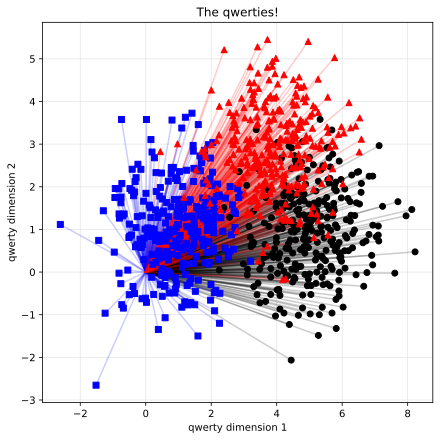

In [18]:
# a function that creats data
nPerClust = 300

A = [1, 1]
B = [5, 1]
C = [4, 3]

# generate data
a = [A[0] + np.random.randn(nPerClust), A[1]+np.random.randn(nPerClust)]
b = [B[0] + np.random.randn(nPerClust), B[1]+np.random.randn(nPerClust)]
c = [C[0] + np.random.randn(nPerClust), C[1]+np.random.randn(nPerClust)]

# true labels
labels_np = np.hstack((np.zeros((nPerClust)), 
                        np.ones((nPerClust)), 
                        1+np.ones((nPerClust)) ))
# concatenate into a matrix
data_np = np.hstack((a, b, c)).T

data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long()

# show the data
fig = plt.figure(figsize=(7,7))

# draw distance to origin
color = 'bkr'
for i in range(len(data)):
    plt.plot([0, data[i, 0]],[0, data[i, 1]], color=color[labels[i]], alpha=.2)

plt.plot(data[np.where(labels==0)[0], 0], data[np.where(labels==0)[0], 1], 'bs')
plt.plot(data[np.where(labels==1)[0], 0], data[np.where(labels==1)[0], 1], 'ko')
plt.plot(data[np.where(labels==2)[0], 0], data[np.where(labels==2)[0], 1], 'r^')

plt.grid(color=[.9, .9, .9])
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

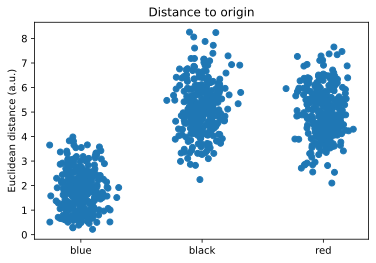

In [19]:
# compute Euclidean distance to the origin
dist2orig = torch.sqrt(data[:, 0]**2 + data[:, 1]**2)

plt.plot(labels + torch.randn(900)/ 10, dist2orig, 'o')
plt.xticks([0, 1, 2], labels=['blue', 'black', 'red'])
plt.ylabel('Euclidean distance (a.u.)')
plt.title('Distance to origin')
plt.show()

In [20]:
# And add that to the data matrix
dataAug = torch.cat((data, dist2orig.view(len(data), 1)), axis=1)

# check data sizes
print(data.shape)
print(dataAug.shape)
print(' ')

# look at some of the data
print(dataAug)

torch.Size([900, 2])
torch.Size([900, 3])
 
tensor([[0.3984, 0.4320, 0.5876],
        [0.0606, 1.0359, 1.0377],
        [1.3728, 0.4740, 1.4523],
        ...,
        [6.5226, 2.8143, 7.1039],
        [5.0851, 3.7134, 6.2966],
        [3.4396, 0.2588, 3.4493]])


In [21]:
# use scikit learn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(dataAug, labels, test_size=.2)

# then convert them into pytorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# finally, translate into dataloader objects
batchsize = 16
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])


## Create the model

In [22]:
# create a class for the model
def createTheQwertyNet(useExtraFeature=False):

    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()


            ## input layer
            if useExtraFeature:
                self.input = nn.Linear(3, 8)
            else:
                self.input = nn.Linear(2, 8)
                
            ## hidden layers
            self.fc1 = nn.Linear(8, 8)

            ## output layer
            self.output = nn.Linear(8, 3)

        # forward pass
        def forward(self, x):

            # by request, only use XY features
            # print(x.shape) # comment during training
            if not useExtraFeature:
                x = x[:, :2]
            # print(x.shape) # comment during training

            # input layer
            x = F.relu(self.input(x))

            # hidden layers
            x = F.relu(self.fc1(x))

            # output layers
            x = F.relu(self.output(x))
            
            return x

    # create the model instance
    net = qwertyNet()

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=.01)

    return net, lossfun, optimizer




In [23]:
# test the model with fake input
print('Using augmented feature:')
net = createTheQwertyNet(True)[0]
net(next(iter(train_loader))[0]);

print('\nNot using augmented feature:')
net = createTheQwertyNet(False)[0]
net(next(iter(train_loader))[0]);

Using augmented feature:

Not using augmented feature:


In [24]:
# a function that train the model

def function2trainTheModel(useExtraFeature):
    numepochs = 200

    # create a new model
    net, lossfun, optimizer = createTheQwertyNet(useExtraFeature)

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):
        
        #switch to training mode
        net.train()


        batchLoss = []
        batchAcc = []
        # loop over batches
        for X, y in train_loader:

            #forward pass
            yHat = net(X)
            loss = lossfun(yHat, y)

            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat, axis=1) == y
            matchesNumeric = matches.float()
            accuracyPct = 100 * torch.mean(matchesNumeric)
            batchAcc.append(accuracyPct)

        # end of batch loop

        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        net.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)

        # compare the following really long line of code to the training accuracy lines
        testAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()))
    # end epochs

    # function outputs
    return trainAcc, testAcc, losses, net

## A Function that plots the results

In [25]:
def plotTheResults():

    # compute accuracy over entire dataset(train+test)
    yHat = net(dataAug)
    predictions = torch.argmax(yHat, axis=1)    
    accuracy = (predictions == labels).float()

    # and accuracy by group
    accuracyByGroup = np.zeros(3)
    for i in range(3):
        accuracyByGroup[i] = 100 * torch.mean(accuracy[labels == i])

    # create the figure
    fig, ax = plt.subplots(2,2, figsize=(10, 6))

    # plot the loss function
    ax[0, 0].plot(losses.detach())
    ax[0, 0].set_ylabel('Loss')
    ax[0, 0].set_xlabel('epoch')
    ax[0, 0].set_title('Losses')

    # plot the accuracy function
    ax[0, 1].plot(trainAcc, label='Train')
    ax[0, 1].plot(testAcc, label='Test')
    ax[0, 1].set_ylabel('Accuracy (%)')
    ax[0, 1].set_xlabel('Epoch')
    ax[0, 1].set_title('Accuracy')
    ax[0, 1].legend()

    # plot overall accuracy by group
    ax[1, 0].bar(range(3), accuracyByGroup)
    ax[1, 0].set_ylim([np.min(accuracyByGroup) - 5, np.max(accuracyByGroup) + 5])
    ax[1, 0].set_xticks([0, 1, 2])
    ax[1, 0].set_xlabel('Group')
    ax[1, 0].set_ylabel('Accuracy (%)')
    ax[1, 0].set_title('Accuracy by group')

    # scatterplot of correct and incorrect labeld data
    colorShapes = ['bs', 'ko', 'g^'] # data markers
    for i in range(3):
        # plot all data points
        ax[1, 1].plot(dataAug[labels==i, 0], dataAug[labels==i, 1], colorShapes[i], alpha=.3, label=f'Group {i}')

        # cross-out the incorrect ones
        idxErr = (accuracy==0) & (labels == i)
        ax[1, 1].plot(dataAug[idxErr, 0], dataAug[idxErr, 1], 'rx')

    ax[1, 1].set_title('All groups')
    ax[1, 1].set_xlabel('qwerty dimension 1')
    ax[1, 1].set_ylabel('qwerty dimension 2')
    ax[1, 1].legend()

    plt.tight_layout()
    plt.show()


Final accuracy: 83.89%


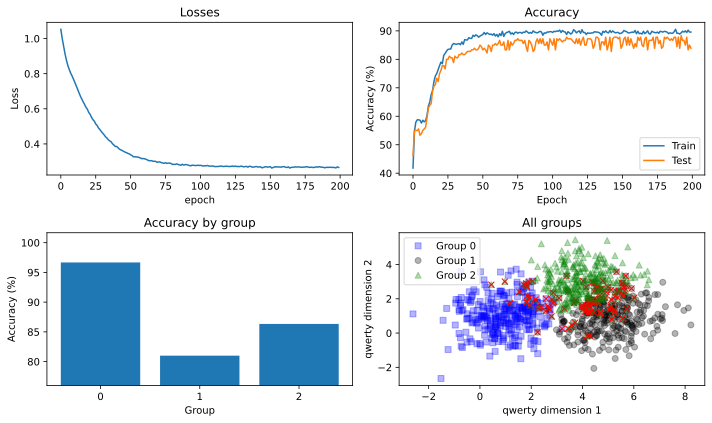

In [26]:
# run the model and visualize the results
trainAcc, testAcc, losses, net = function2trainTheModel(False)
print('Final accuracy: %.2f%%'%testAcc[-1].item())
plotTheResults()

Final accuracy: 65.00%


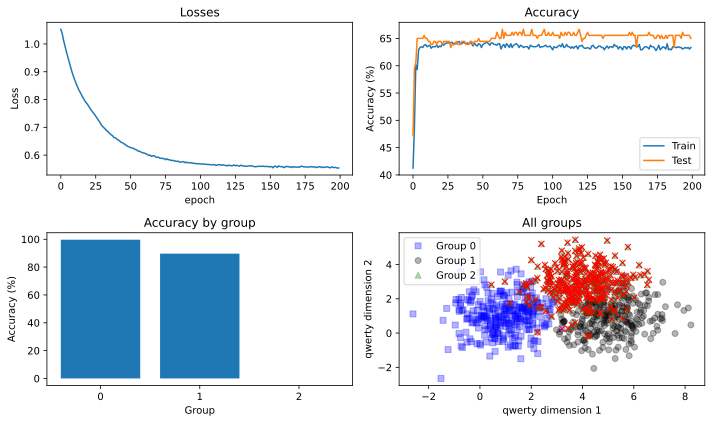

In [27]:
# run the model and visualize the results
trainAcc, testAcc, losses, net = function2trainTheModel(True)
print('Final accuracy: %.2f%%'%testAcc[-1].item())
plotTheResults()

## Now for the experiment!

In [30]:
# Run the experiment multiple times and do a t-test

finalacc2 = np.zeros(10)
finalacc3 = np.zeros(10)

for i in range(10):
    finalacc2[i] = function2trainTheModel(False)[1][-1]
    finalacc3[i] = function2trainTheModel(True)[1][-1]

# show the numbers
print(np.round(np.vstack((finalacc2, finalacc3)).T, 2))

# run the t-test and print the results
from scipy import stats
t, p = stats.ttest_ind(finalacc3, finalacc2)
print('\n\nt=%.2f, p=%.2f'%(t, p))


[[65.56 33.89]
 [85.   57.22]
 [87.22 33.89]
 [57.78 57.78]
 [87.22 86.11]
 [33.89 82.78]
 [87.78 82.22]
 [33.89 65.56]
 [85.   83.33]
 [65.56 86.11]]


t=-0.21, p=0.83
